In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
local_dir = 's18-transformer-speeding-up-strategy'
repo_url = 'https://github.com/aakashvardhan/s18-transformer-speeding-up-strategy.git'

# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone --quiet {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

In [3]:
import sys
sys.path.append('/content/s18-transformer-speeding-up-strategy')

In [4]:
!pip install -q -r /content/s18-transformer-speeding-up-strategy/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.1 MB/s eta 0:00:00


In [5]:
%cd /content/s18-transformer-speeding-up-strategy

/content/s18-transformer-speeding-up-strategy


In [6]:
from config_file import get_config
from main import main

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Directory 'weights' created!
Seed set to 42...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Max length of the source sentence : 309
Max length of the source target : 274
DataModule initialized...


INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of the source sentence : 309
Max length of the source target : 274
Saving model to weights/tmodel_0.pt
Saving model to weights/tmodel_0.pt


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finding best initial lr:   0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO: `Trainer.fit` stopped: `max_steps=18` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=18` reached.
INFO: Learning rate set to 0.005994842503189409
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005994842503189409
INFO: Restoring states from the checkpoint path at weights/.lr_find_b6b7efe2-700f-4c9d-a1d9-da50f378f67e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at weights/.lr_find_b6b7efe2-700f-4c9d-a1d9-da50f378f67e.ckpt
INFO: Restored all states from the checkpoint at weights/.lr_find_b6b7efe2-700f-4c9d-a1d9-da50f378f67e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at weights/.lr_find_b6b7efe2-700

Suggested learning rate: 0.005994842503189409


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /content/s18-transformer-speeding-up-strategy/weights exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Transformer      | 53.1 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
53.1 M    Trainable params
0         Non-trainable params
53.1 M    Total params
212.390   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Transformer      | 53.1 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------

Max length of the source sentence : 309
Max length of the source target : 274


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: And, O ma'am! I wish the woollen stockings were better looked to!--when I was here last, I went into the kitchen-garden and examined the clothes drying on the line; there was a quantity of black hose in a very bad state of repair: from the size of the holes in them I was sure they had not been well mended from time to time."
    TARGET: — A proposito, signora, vorrei che le calze di lana fossero in migliore stato. Quando venni qui l'ultima volta, esaminai il bucato steso sulle corde in giardino, e vidi le calze nere così rotte da far ritenere che da un pezzo non fossero state rammendate.
 PREDICTED: aggrappa aggrappa procacciarmi procacciarmi accolto accolto accolto accolto complotto complotto complotto complotto complotto complotto accolto accolto accolto complotto complotto complotto complotto complotto complotto complotto complotto accolto accolto accolto accolto accolto accolto accolto acco

Training: |          | 0/? [00:00<?, ?it/s]

ValueError: Caught ValueError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/content/s18-transformer-speeding-up-strategy/dataset.py", line 50, in __getitem__
    raise ValueError("Sentence too long")
ValueError: Sentence too long


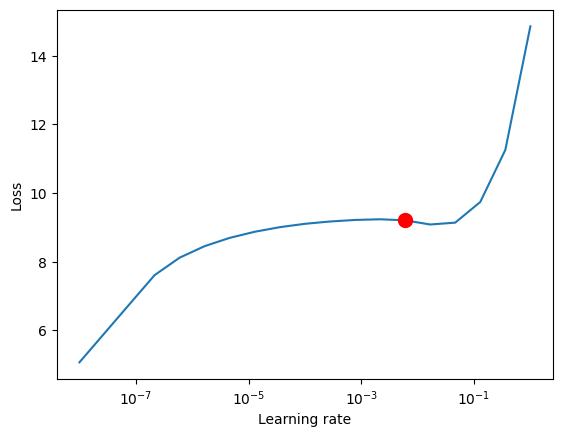

In [7]:
cfg = get_config()
cfg['batch_size'] = 24
cfg['num_epochs'] = 18
main(cfg,debug=False)

In [ ]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir /content/s18-transformer-speeding-up-strategy/lightning_logs